In [2]:
import datetime
import os
import sys
import time as tm

import cartopy.crs as ccrs
import matplotlib.dates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import netCDF4 as nc
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as pyo
from scipy.interpolate import griddata
from tqdm.notebook import tqdm

# Región CORDEX
La región de nuestro interés es la región 1, que corresponde a la región de América del Sur.  https://cordex.org/domains/cordex-region-south-america-cordex/  

Existen múltiples sub-regiones dentro de esta región.

c:\Software\anaconda3\lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



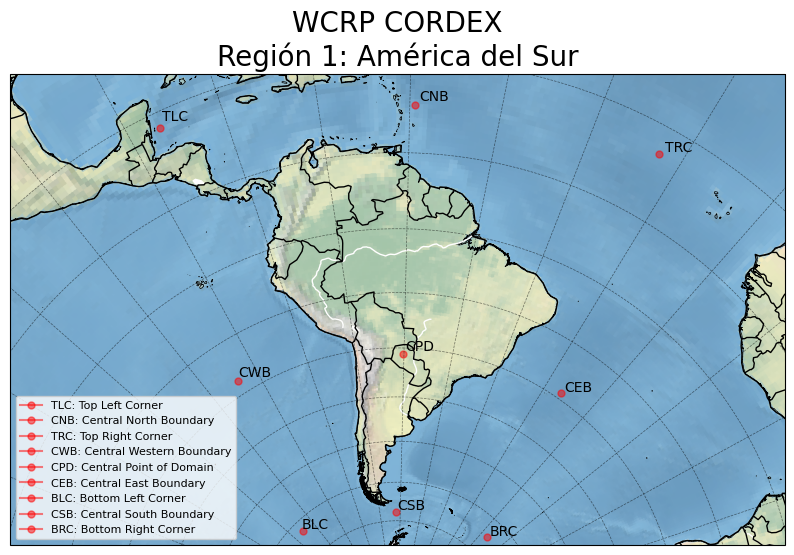

In [3]:
# For non-rotated polar RCMs (in actual coordinates):
coords = {'TLC': (273.26, 18.50), 'CNB': (300.56, 15.40), 'TRC': (327.52, 17.23), 'CWB': (265.88, -17.30), 'CPD': (299.70, -21.11), 'CEB': (333.36, -18.84), 'BLC': (254.28, -52.66), 'CSB': (298.13, -57.61), 'BRC': (343.02, -54.6)}
names = {'TLC': 'Top Left Corner', 'CNB': 'Central North Boundary', 'TRC': 'Top Right Corner', 'CWB': 'Central Western Boundary', 'CPD': 'Central Point of Domain', 'CEB': 'Central East Boundary', 'BLC': 'Bottom Left Corner', 'CSB': 'Central South Boundary', 'BRC': 'Bottom Right Corner'}

# Encontramos el mínimo y máximo para las longitudes
min_lon = min([coords[i][0] for i in coords.keys()])
max_lon = max([coords[i][0] for i in coords.keys()])
# Encontramos el mínimo y máximo para las latitudes
min_lat = min([coords[i][1] for i in coords.keys()])
max_lat = max([coords[i][1] for i in coords.keys()])

# Definimos la proyección
proj = ccrs.SouthPolarStereo(central_longitude=(min_lon + max_lon) / 2, true_scale_latitude=(min_lat + max_lat) / 2)

# Definimos el tamaño de la figura
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Definimos el área de visualización
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
# Definimos el meridiano y paralelo
ax.gridlines(xlocs=np.arange(-180, 180, 10), ylocs=np.arange(-90, 90, 10), crs=ccrs.PlateCarree(), color='black', alpha=0.5, linestyle='--', linewidth=0.5)
# Definimos el contorno
ax.coastlines(resolution='10m', color='black', linewidth=0.5)

# Definimos el título
ax.set_title('WCRP CORDEX\nRegión 1: América del Sur', fontsize=20)

# Definimos el color
ax.stock_img()
ax.add_feature(ccrs.cartopy.feature.LAND, color='white')
ax.add_feature(ccrs.cartopy.feature.OCEAN, color='white')
ax.add_feature(ccrs.cartopy.feature.LAKES, color='white')
ax.add_feature(ccrs.cartopy.feature.RIVERS, color='white')
ax.add_feature(ccrs.cartopy.feature.BORDERS, color='black')
ax.add_feature(ccrs.cartopy.feature.COASTLINE, color='black')

# Agregamos los puntos y sus nombres
for i in coords.keys():
    ax.plot(coords[i][0], coords[i][1], marker='o', markersize=5, color='red', alpha=0.5, transform=ccrs.PlateCarree(), label=i+': '+names[i])
    ax.text(coords[i][0] + 0.5, coords[i][1] + 0.5, i, horizontalalignment='left', transform=ccrs.PlateCarree())

# Agregamos la leyenda
ax.legend(loc='lower left', fontsize=8)

# Mostramos la figura
plt.show()



# Búsqueda de modelos
Descargamos los modelos CORDEX desde la red ESFG  
<a href="http://esg-dn1.nsc.liu.se/" ><strong>SMHI-NSC, Sweden</strong></a>  
<a href="http://esgf-data.dkrz.de/" ><strong>DKRZ, Germany</strong></a>  
<a href="http://esgf-data.dkrz.de/" ><strong>DKRZ, Germany</strong></a>  
<a href="https://esgf-node.ipsl.upmc.fr" ><strong>IPSL, France</strong></a>
<br><br>
La variable de interés es la humedad específica (huss / Near-Surface Specific Humidity)  
  
Con las siguientes restricciones:  
Search Constraints:   mon | huss | SAM-22,SAM-44,SAM-44i | r1i1p1  
  
Encontramos 24 modelos históricos y 57 RCP

In [5]:
cordex_models_path = './cordex_models/historical/huss/'
# cordex_models serán solo las carpetas contenidas en cordex_models_path, no archivos sueltos
cordex_models = [f for f in os.listdir(cordex_models_path) if os.path.isdir(os.path.join(cordex_models_path, f))]
# Cargamos los modelos
cordex_datasets = [nc.MFDataset(os.path.join(cordex_models_path, model, '*.nc')) for model in cordex_models]
print(f'Cantidad de modelos cargados: {len(cordex_datasets)}')
print(f"\nCantidad de modelos por dominio\n{pd.Series([cordex_datasets[i].CORDEX_domain for i in range(len(cordex_datasets))]).value_counts().to_string()}")
print(f"\nCantidad de modelos por institución\n{pd.Series([cordex_datasets[i].institute_id for i in range(len(cordex_datasets))]).value_counts().to_string()}")
print(f"\nCantidad de modelos por driving model\n{pd.Series([cordex_datasets[i].driving_model_id for i in range(len(cordex_datasets))]).value_counts().to_string()}")


Cantidad de modelos cargados: 24

Cantidad de modelos por dominio
SAM-44     10
SAM-44i     8
SAM-22      6

Cantidad de modelos por institución
SMHI       17
GERICS      3
ICTP        3
MPI-CSC     1

Cantidad de modelos por driving model
MOHC-HadGEM2-ES              4
MPI-M-MPI-ESM-LR             4
NCC-NorESM1-M                4
CCCma-CanESM2                2
CSIRO-QCCCE-CSIRO-Mk3-6-0    2
IPSL-IPSL-CM5A-MR            2
MIROC-MIROC5                 2
NOAA-GFDL-GFDL-ESM2M         2
MPI-M-MPI-ESM-MR             1
CNRM-CERFACS-CNRM-CM5        1


Exploramos las variables de cada modelo

In [4]:

print('{0:^135} {1:<15} {2:<30} {3:<15}\n'.format('Variables', 'Institución', 'Driving model', 'Dominio'))
for model in sorted(cordex_datasets, key=lambda x: len(x.variables.keys())):
    print('{0:<135} {1:<15} {2:<30} {3:<15}'.format(str(list(model.variables.keys())), model.institute_id, model.driving_model_id, model.CORDEX_domain))


                                                               Variables                                                                Institución     Driving model                  Dominio        

['lon', 'lat', 'time', 'time_bnds', 'huss', 'height']                                                                                   SMHI            CCCma-CanESM2                  SAM-44i        
['lon', 'lat', 'time', 'time_bnds', 'huss', 'height']                                                                                   SMHI            CSIRO-QCCCE-CSIRO-Mk3-6-0      SAM-44i        
['lon', 'lat', 'time', 'time_bnds', 'huss', 'height']                                                                                   SMHI            IPSL-IPSL-CM5A-MR              SAM-44i        
['lon', 'lat', 'time', 'time_bnds', 'huss', 'height']                                                                                   SMHI            MIROC-MIROC5                   SAM-44i        
['lo

Exploramos las dimensiones de la serie de tiempo y las de las longitudes y latitudes

In [5]:
print('{0:^20} {1:^20} {2:^20}'.format('huss.shape', 'lat.shape', 'lon.shape'))
for model in sorted(cordex_datasets, key=lambda x: len(x.variables.keys())):
    print('{0:^20} {1:^20} {2:^20}'.format(str(model['huss'].shape), str(model['lat'].shape), str(model['lon'].shape)))

     huss.shape           lat.shape            lon.shape      
  (660, 155, 181)           (155,)               (181,)       
  (660, 155, 181)           (155,)               (181,)       
  (660, 155, 181)           (155,)               (181,)       
  (660, 155, 181)           (155,)               (181,)       
  (660, 155, 181)           (155,)               (181,)       
  (660, 155, 181)           (155,)               (181,)       
  (660, 155, 181)           (155,)               (181,)       
  (660, 155, 181)           (155,)               (181,)       
  (432, 360, 330)         (360, 330)           (360, 330)     
  (432, 360, 330)         (360, 330)           (360, 330)     
  (432, 360, 330)         (360, 330)           (360, 330)     
  (660, 167, 146)         (167, 146)           (167, 146)     
  (660, 167, 146)         (167, 146)           (167, 146)     
  (660, 167, 146)         (167, 146)           (167, 146)     
  (660, 167, 146)         (167, 146)           (167, 14

Exploramos la disposición de un dataset con latitudes y longitudes en 2D

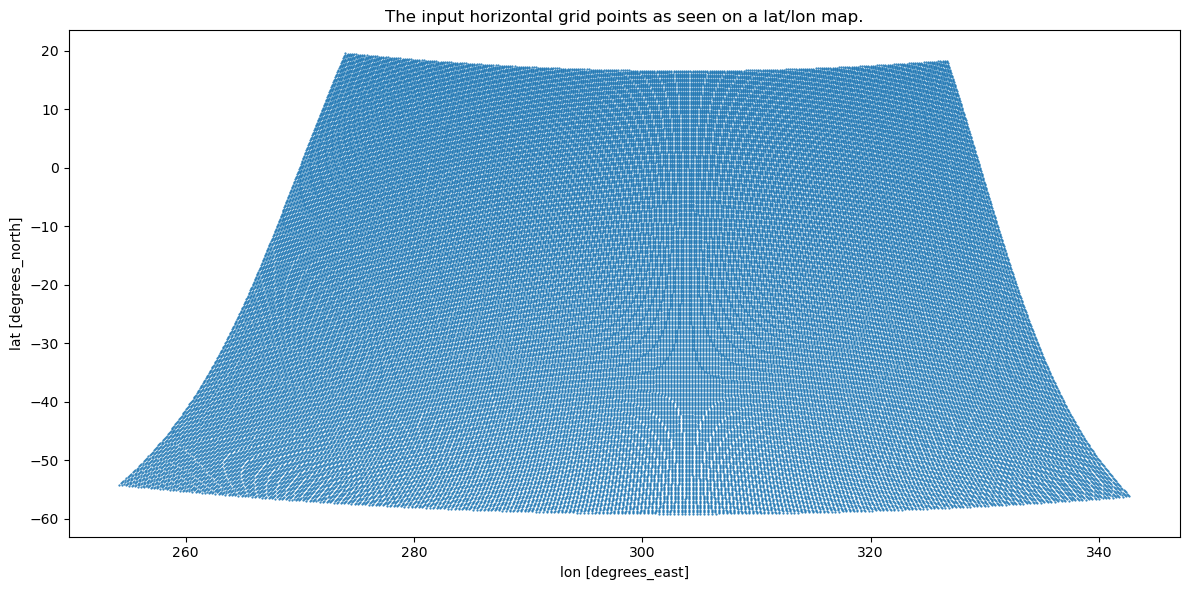

In [6]:
# Let's look at the grid shape itself and the data for one time step
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))

ax.scatter(x=cordex_datasets[0]['lon'][:], y=cordex_datasets[0]['lat'][:], s=0.3)
ax.set_title("The input horizontal grid points as seen on a lat/lon map.")
ax.set_ylabel(f"lat [{cordex_datasets[0]['lat'].units}]")
ax.set_xlabel(f"lon [{cordex_datasets[0]['lon'].units}]")
fig.tight_layout()




No sé como trabajar con las latitudes/longitudes en dos dimensiones asi que únicamente trabajare con los de una dimensión.  
Filtramos los modelos que tienen latitudes y longitudes en una dimensión

In [7]:
# Modelos con latitudes/longitudes de una sola dimensión
cordex_datasets_1d = [cordex_datasets[i] for i in range(len(cordex_datasets)) if len(cordex_datasets[i]['lat'].shape) == 1 and len(cordex_datasets[i]['lon'].shape) == 1]
print(f"\nCantidad de modelos por dominio\n{pd.Series([cordex_datasets_1d[i].CORDEX_domain for i in range(len(cordex_datasets_1d))]).value_counts().to_string()}")


Cantidad de modelos por dominio
SAM-44i    8


In [8]:
def show_extent_of_cordex_models(model_array, plot_cols=3):
    if len(model_array) < plot_cols:
        plot_cols = len(model_array)

    nrows_config = int(np.ceil(len(model_array) / plot_cols))
    nsubplots_config = len(model_array)
    figsize_config = (plot_cols * 2.5, nrows_config * 2.5)
    subplot_kw_config = {'projection': ccrs.Robinson()}
    
    fig, ax = plt.subplots(nrows=nrows_config, ncols=plot_cols, figsize=figsize_config, subplot_kw=subplot_kw_config)
    for axi, model in zip(ax.flatten(), model_array):
        var_name = model.variables[list(model.variables.keys())[-1]].long_name
        cordex_domain = model.CORDEX_domain
        driving_model = model.driving_model_id
        model_id = model.model_id
        title = '%s ; %s\n%s\n%s' % (driving_model, model_id, cordex_domain, var_name)

        model_points = np.array([(lat, lon) for lat in model.variables['lat'][:].flatten() for lon in model.variables['lon'][:].flatten()])
        min_lon = min(model.variables['lon'][:].flatten())
        max_lon = max(model.variables['lon'][:].flatten())
        min_lat = min(model.variables['lat'][:].flatten())
        max_lat = max(model.variables['lat'][:].flatten())
        

        axi.coastlines(resolution='10m', color='black', linewidth=0.5)
        axi.add_feature(ccrs.cartopy.feature.BORDERS, color='black')
        axi.scatter(model_points[:, 1], model_points[:, 0], transform=ccrs.PlateCarree(), s=1)
        axi.set_extent([min_lon-5, max_lon+5, min_lat-5, max_lat+5], crs=ccrs.PlateCarree())
        axi.set_title(title, fontsize=8)
    # Delete empty subplots
    for i in range(nsubplots_config, nrows_config * plot_cols):
        fig.delaxes(ax.flatten()[i])
    fig.tight_layout()
    plt.show()

c:\Software\anaconda3\lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



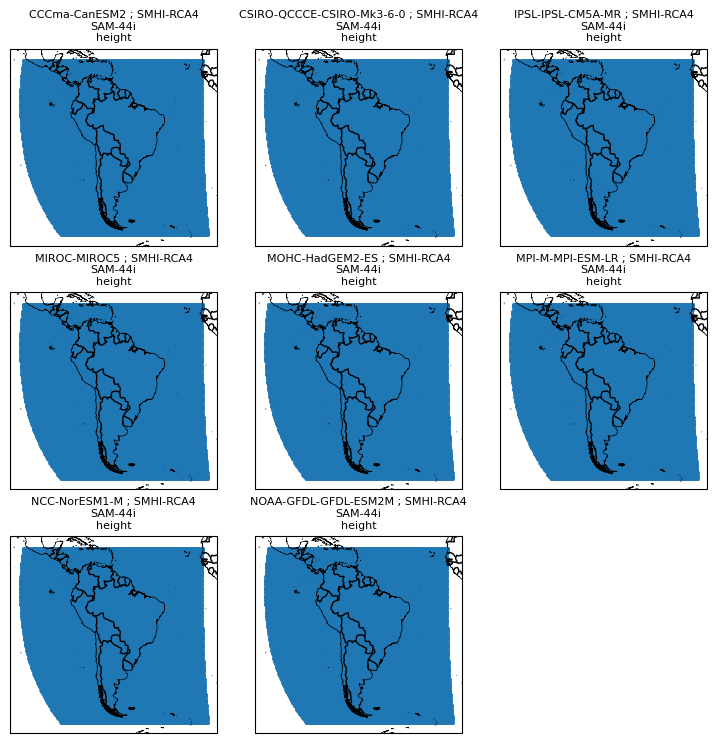

In [9]:
show_extent_of_cordex_models(cordex_datasets_1d, plot_cols=3)

In [10]:
def monthly_mean(time_series, lat, lon):
    """
    Calcula el promedio mensual de una serie de tiempo. Considera únicamente años completos.
    Input:
        time_series: Serie de tiempo a la cual se le calculará el promedio mensual
        lat: Arreglo de latitudes
        lon: Arreglo de longitudes
    Output:
        monthly_mean: Promedio mensual de la serie de tiempo
    """
    complete_years = time_series.shape[0] // 12
    monthly_mean = np.mean(time_series[:complete_years*12].reshape(-1, 12, lat.shape[0], lon.shape[0]), axis=0)
    return monthly_mean

def monthly_regression(time_series):
    """
    Realiza un ajuste de regresión lineal periódica a una serie de tiempo.

    Argumentos:
    - time_series: Un array de forma (N,), donde N es el número de períodos en la serie de tiempo.
    
    Retorna:
    - adjusted_time_series : Un array de forma (N,), que representa la serie de tiempo ajustada mediante la regresión lineal periódica.
    """

    num_periods = time_series.shape[0]

    # Crea una matriz de predictores con características periódicas
    predictors = np.ones((num_periods, 5))
    time = np.arange(1, 13)
    predictors[:, 1] = np.cos(2 * np.pi * time / 12)
    predictors[:, 2] = np.sin(2 * np.pi * time / 12)
    predictors[:, 3] = np.cos(4 * np.pi * time / 12)
    predictors[:, 4] = np.sin(4 * np.pi * time / 12)

    # Realiza una regresión lineal periódica
    coefficients = np.linalg.lstsq(predictors, time_series, rcond=None)[0]

    # Calcula la serie de tiempo ajustada
    adjusted_time_series  = np.matmul(predictors, coefficients)

    return adjusted_time_series

def monthly_anomaly_series(time_series, lat_series, lon_series):
    """
    Calcula la serie de anomalías de una serie de tiempo removiendo el ciclo estacional. Considera únicamente años completos.
    Input:
        time_series: Serie de tiempo a la cual se le calculará la serie de anomalías
        lat_series: Arreglo de latitudes
        lon_series: Arreglo de longitudes
    Output:
        monthly_anomaly_series: Serie de anomalías de la serie de tiempo
        series_monthly_mean_fit: Serie de tiempo ajustada mediante la regresión lineal periódica
        series_monthly_mean: Promedio mensual de la serie de tiempo
    """
    complete_years = time_series.shape[0] // 12
    series_monthly_mean = monthly_mean(time_series, lat_series, lon_series)
    serie_monthly_mean_fit_aux = np.zeros(series_monthly_mean.shape)
    for j in range(len(lon_series)):
        for i in range(len(lat_series)):
            serie_monthly_mean_fit_aux[:, i, j] = monthly_regression(series_monthly_mean[:, i, j])
    series_monthly_mean_fit = np.tile(serie_monthly_mean_fit_aux, (complete_years, 1, 1))
    monthly_anomaly_series = time_series - series_monthly_mean_fit
    return monthly_anomaly_series, series_monthly_mean_fit, series_monthly_mean

def init_models_dict(cordex_datasets):
    """
    Crea un diccionario con los modelos de CORDEX.
    Input:
        cordex_datasets: Lista de modelos de CORDEX
    Output:
        models_dict: Diccionario con los modelos de CORDEX
    """
    models_dict = {}
    content = {
        'anomaly_series': None,
        'monthly_mean_fit': None,
        'monthly_mean': None,
        'lat': None,
        'lon': None,
        'time': None,
        'huss': None,
        'model_id': None,
        'driving_model_id': None,
        'cordex_domain': None,
    }
    for model in cordex_datasets:
        model_name = model.model_id + '_' + model.driving_model_id + '_' + model.CORDEX_domain
        models_dict[model_name] = content.copy()
    return models_dict


In [11]:
# Inicializamos el diccionario de modelos
models_data = init_models_dict(cordex_datasets_1d)
# Iteramos sobre los modelos
for model in tqdm(cordex_datasets_1d):
    # Obtenemos el nombre del modelo
    model_name = model.model_id + '_' + model.driving_model_id + '_' + model.CORDEX_domain 
    # Obtenemos la serie de tiempo de la variable huss
    time_series_data = model['huss'][:]
    # Obtenemos las latitudes y longitudes
    lat_data = model['lat'][:]
    lon_data = model['lon'][:]
    # Calculamos la serie de anomalías
    anomaly_series_iter, monthly_mean_fit_iter, monthly_mean_iter = monthly_anomaly_series(time_series_data, lat_data, lon_data)
    
    # Guardamos los datos en el diccionario
    models_data[model_name]['anomaly_series'] = anomaly_series_iter
    models_data[model_name]['monthly_mean_fit'] = monthly_mean_fit_iter
    models_data[model_name]['monthly_mean'] = monthly_mean_iter
    models_data[model_name]['lat'] = lat_data
    models_data[model_name]['lon'] = lon_data
    # Transformamos el tiempo a datetime, los valores corresponden a days since 1949-12-01T00:00:00Z
    models_data[model_name]['time'] = [datetime.datetime(1949, 12, 1) + datetime.timedelta(days=int(i)) for i in model['time'][:]]
    models_data[model_name]['huss'] = model['huss'][:]
    models_data[model_name]['model_id'] = model.model_id
    models_data[model_name]['driving_model_id'] = model.driving_model_id
    models_data[model_name]['cordex_domain'] = model.CORDEX_domain
    print(f'Anomalías calculadas para {model_name}.')

  0%|          | 0/8 [00:00<?, ?it/s]

Anomalías calculadas para SMHI-RCA4_CCCma-CanESM2_SAM-44i.
Anomalías calculadas para SMHI-RCA4_CSIRO-QCCCE-CSIRO-Mk3-6-0_SAM-44i.
Anomalías calculadas para SMHI-RCA4_IPSL-IPSL-CM5A-MR_SAM-44i.
Anomalías calculadas para SMHI-RCA4_MIROC-MIROC5_SAM-44i.
Anomalías calculadas para SMHI-RCA4_MOHC-HadGEM2-ES_SAM-44i.
Anomalías calculadas para SMHI-RCA4_MPI-M-MPI-ESM-LR_SAM-44i.
Anomalías calculadas para SMHI-RCA4_NCC-NorESM1-M_SAM-44i.
Anomalías calculadas para SMHI-RCA4_NOAA-GFDL-GFDL-ESM2M_SAM-44i.


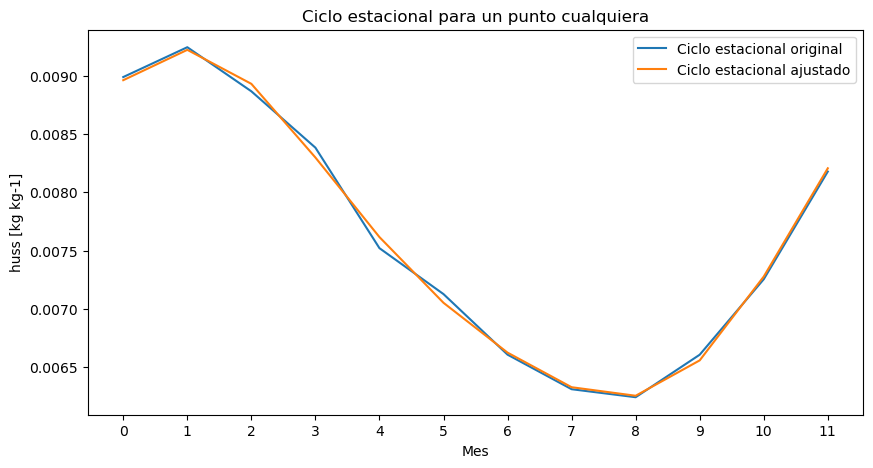

In [12]:
# Gráficamos el ciclo estacional para comprobar si esta bien calculado, en un punto cualquiera.

i = 50
j = 60

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(models_data['SMHI-RCA4_CCCma-CanESM2_SAM-44i']['monthly_mean'][:, i, j], label='Ciclo estacional original')
ax.plot(models_data['SMHI-RCA4_CCCma-CanESM2_SAM-44i']['monthly_mean_fit'][0:12, i, j], label='Ciclo estacional ajustado')
ax.set_title('Ciclo estacional para un punto cualquiera')
ax.set_xlabel('Mes')
ax.set_ylabel('huss [kg kg-1]')
ax.set_xticks(np.arange(0, 12, 1))
ax.legend()

plt.show()

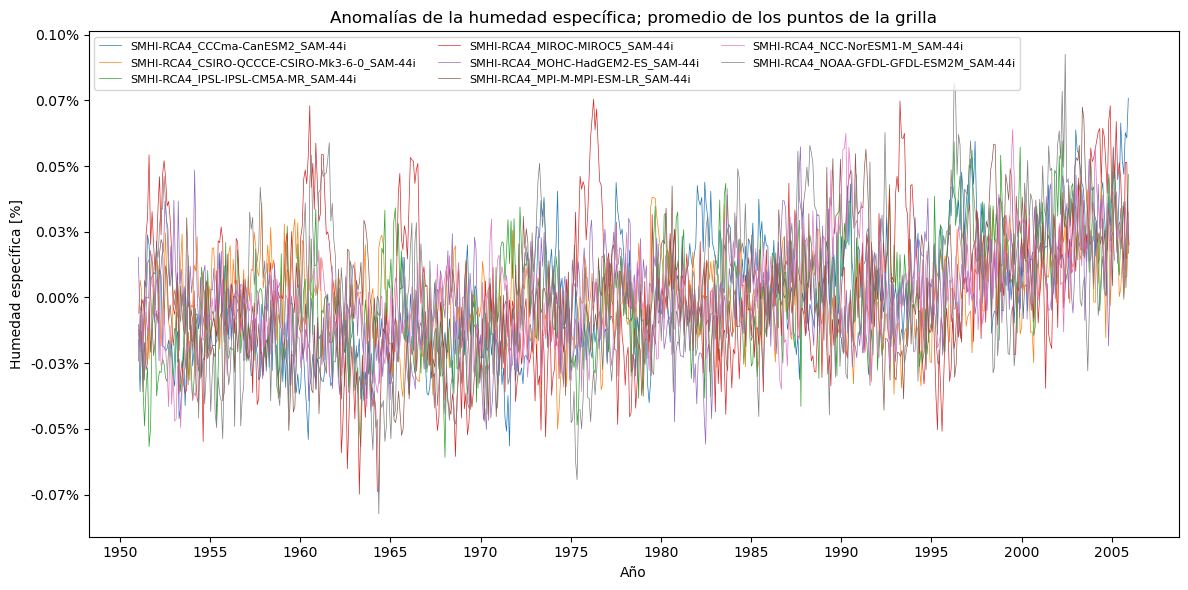

In [13]:
def percent_formatter(x, pos):
    return '{:.2f}%'.format(x*100)

# Graficamos las series de tiempo de las anomalías
fig, ax = plt.subplots(ncols=1, figsize=(12, 6))
for model in models_data.keys():
    ax.plot(models_data[model]['time'], models_data[model]['anomaly_series'].mean(axis=(1, 2)), label=model, lw=0.5)
ax.set_title('Anomalías de la humedad específica; promedio de los puntos de la grilla')
ax.set_ylabel(f"Humedad específica [%]")
ax.set_xlabel(f"Año")
ax.legend(loc='upper left', fontsize=8, ncol=3)
# Definimos el formato del eje y en porcentaje
ax.yaxis.set_major_formatter(mticker.FuncFormatter(percent_formatter))
# Aumentamos la cantidad de ticks en el eje x desde 1951 a 2005
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(5))

fig.tight_layout()
plt.show()

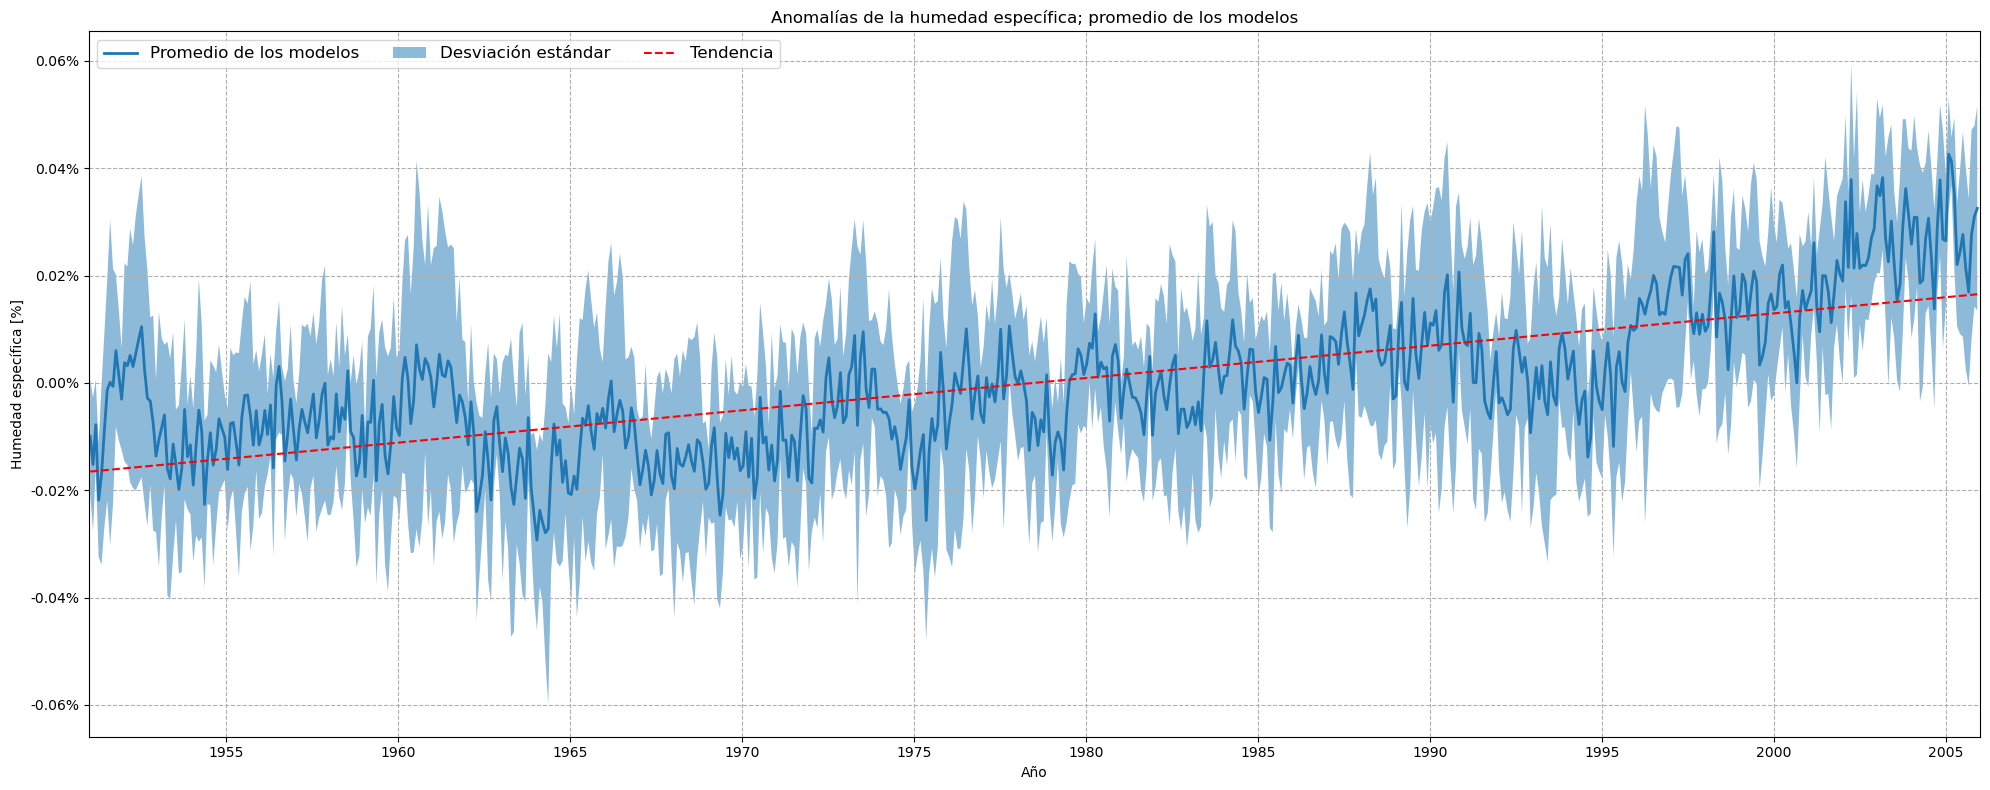

In [25]:
# Promediamos las series de tiempo de los distintos modelos para obtener una serie de tiempo promedio, con barras de error.
anomaly_series_mean = np.zeros((len(models_data['SMHI-RCA4_CCCma-CanESM2_SAM-44i']['anomaly_series']), len(models_data.keys())))
for i, model in enumerate(models_data.keys()):
    anomaly_series_mean[:, i] = models_data[model]['anomaly_series'].mean(axis=(1, 2))
anomaly_series_mean_mean = anomaly_series_mean.mean(axis=1)
anomaly_series_mean_std = anomaly_series_mean.std(axis=1)

# Graficamos la serie de tiempo promedio
fig, ax = plt.subplots(ncols=1, figsize=(20, 8))
ax.plot(models_data['SMHI-RCA4_CCCma-CanESM2_SAM-44i']['time'], anomaly_series_mean_mean, label='Promedio de los modelos', lw=2)
ax.fill_between(models_data['SMHI-RCA4_CCCma-CanESM2_SAM-44i']['time'], anomaly_series_mean_mean - anomaly_series_mean_std, anomaly_series_mean_mean + anomaly_series_mean_std, alpha=0.5, label='Desviación estándar')

# Añadimos una linea de tendencia
z = np.polyfit(matplotlib.dates.date2num(models_data['SMHI-RCA4_CCCma-CanESM2_SAM-44i']['time']), anomaly_series_mean_mean, 1)
p = np.poly1d(z)
ax.plot(models_data['SMHI-RCA4_CCCma-CanESM2_SAM-44i']['time'], p(matplotlib.dates.date2num(models_data['SMHI-RCA4_CCCma-CanESM2_SAM-44i']['time'])), "r--", label='Tendencia')

ax.set_title('Anomalías de la humedad específica; promedio de los modelos')
ax.set_ylabel(f"Humedad específica [%]")
ax.set_xlabel(f"Año")
ax.legend(loc='upper left', fontsize=12, ncol=3)
# Definimos el formato del eje y en porcentaje
ax.yaxis.set_major_formatter(mticker.FuncFormatter(percent_formatter))
# Aumentamos la cantidad de ticks en el eje x desde 1951 a 2005
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(5))
ax.set_xlim([datetime.datetime(1951, 1, 1), datetime.datetime(2005, 12, 31)])
#grid
ax.grid(True, which='both', axis='both', linestyle='--')

fig.tight_layout()
plt.show()


In [14]:
# Mismo gráfico pero en plotly

# Crear una lista de trazas para las series de tiempo
traces = []
for model in models_data.keys():
    trace = go.Scatter(
        x=models_data[model]['time'],
        y=models_data[model]['anomaly_series'].mean(axis=(1, 2)),
        mode='lines',
        name=model,
        line=dict(width=2)
    )
    traces.append(trace)

# Crear el diseño del gráfico
layout = go.Layout(
    title='Anomalías de la humedad específica; promedio de los puntos de la grilla',
    yaxis=dict(
        title='Humedad específica (%)',
        tickformat='.2%',
        rangemode='tozero'
    ),
    xaxis=dict(title='Año'),
    legend=dict(
        x=0,
        y=1,
        traceorder='normal',
        font=dict(size=8),
        orientation='h'
    ),
    autosize=True,
    width=1600,
    height=800,
    plot_bgcolor='lightgray'
)

# Crear la figura con las trazas y el diseño
fig = go.Figure(data=traces, layout=layout)

pyo.plot(fig, filename='output/huss_anomalies_timeseries.html', auto_open=True)

# Mostrar el gráfico interactivo
pio.show(fig)

Text(0.5, 0.98, 'Comparativa de anomalías de humedad específica en Enero\nPrimer año vs. Último año')

c:\Software\anaconda3\lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".



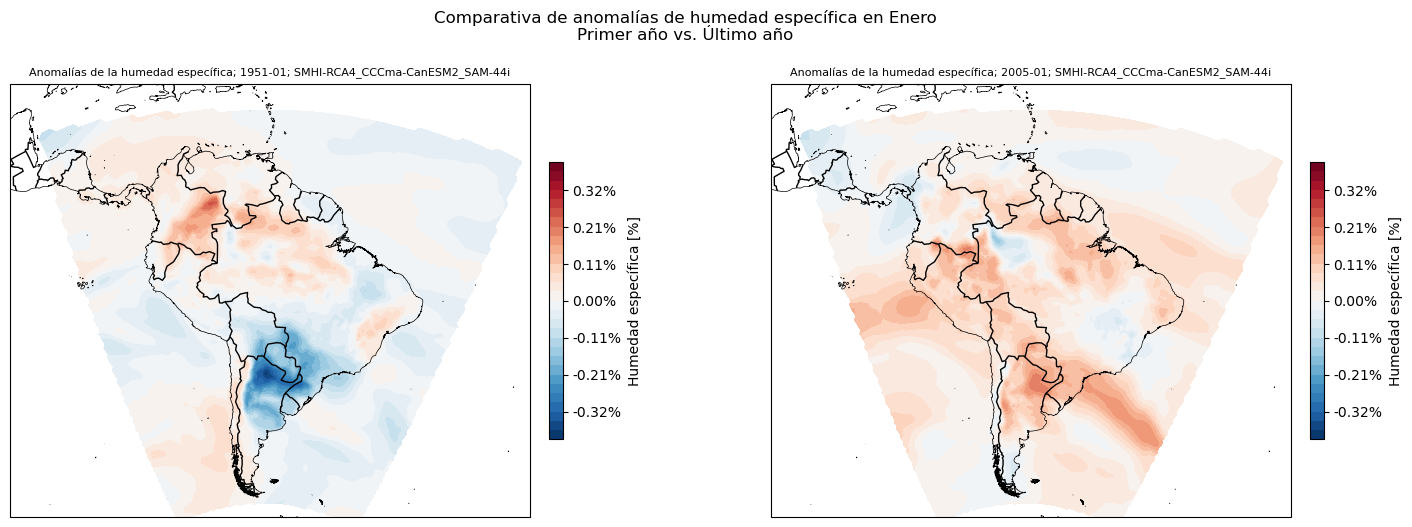

In [15]:
model_name = 'SMHI-RCA4_CCCma-CanESM2_SAM-44i'
fig, ax = plt.subplots(ncols=2, figsize=(
    18, 6), subplot_kw={'projection': proj})
ax[0].set_extent([min_lon+15, max_lon-15, min_lat,
                max_lat], crs=ccrs.PlateCarree())
ax[1].set_extent([min_lon+15, max_lon-15, min_lat,
                max_lat], crs=ccrs.PlateCarree())
levels = np.linspace(-0.0040, 0.0040, 31)

cf = ax[0].contourf(models_data[model_name]['lon'], models_data[model_name]['lat'],
                    models_data[model_name]['anomaly_series'][0, :, :], transform=ccrs.PlateCarree(), cmap='RdBu_r',
                    levels=levels)
cbar = fig.colorbar(cf, ax=ax[0], shrink=0.6, orientation='vertical', pad=0.03)
cbar.set_label('Humedad específica [%]')
cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(percent_formatter))

cf = ax[1].contourf(models_data[model_name]['lon'], models_data[model_name]['lat'],
                    models_data[model_name]['anomaly_series'][-12, :, :], transform=ccrs.PlateCarree(), cmap='RdBu_r',
                    levels=levels)
cbar = fig.colorbar(cf, ax=ax[1], shrink=0.6, orientation='vertical', pad=0.03)
cbar.set_label('Humedad específica [%]')
cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(percent_formatter))

ax[0].coastlines(resolution='10m', color='black', linewidth=0.5)
ax[0].add_feature(ccrs.cartopy.feature.BORDERS, color='black')
date_title = models_data[model_name]['time'][0].strftime('%Y-%m')
ax[0].set_title(f'Anomalías de la humedad específica; %s; %s' % (date_title, model_name), fontsize = 8)

ax[1].coastlines(resolution='10m', color='black', linewidth=0.5)
ax[1].add_feature(ccrs.cartopy.feature.BORDERS, color='black')
date_title = models_data[model_name]['time'][-12].strftime('%Y-%m')
ax[1].set_title(f'Anomalías de la humedad específica; %s; %s' % (date_title, model_name), fontsize = 8)

fig.suptitle('Comparativa de anomalías de humedad específica en Enero\nPrimer año vs. Último año', fontsize=12)





Text(0.5, 0.98, 'Comparativa de anomalías de humedad específica en Enero\nPrimer año vs. Último año')

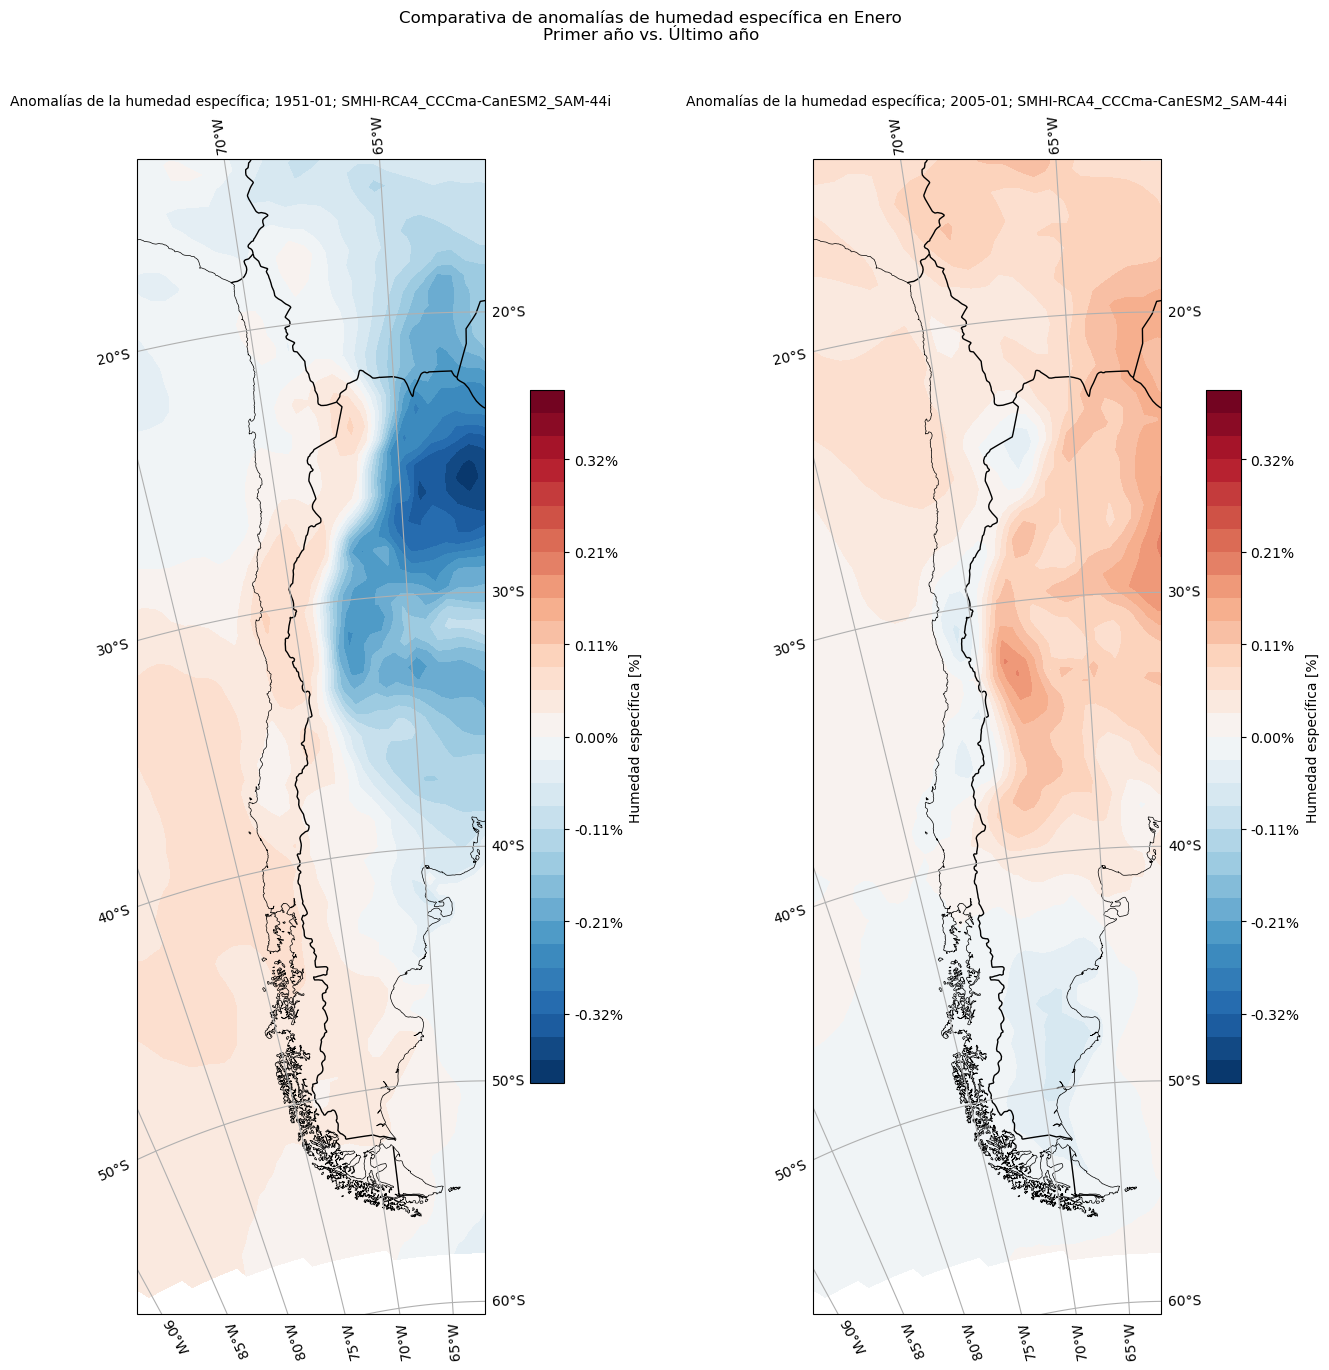

In [16]:
# Graficamos solo para Chile
chile_min_lon = -77
chile_max_lon = -58
chile_min_lat = -60
chile_max_lat = -15

fig, ax = plt.subplots(ncols=2, figsize=(
    16, 15), subplot_kw={'projection': proj})
ax[0].set_extent([chile_min_lon+15, chile_max_lon-15, chile_min_lat,
                chile_max_lat], crs=ccrs.PlateCarree())
ax[1].set_extent([chile_min_lon+15, chile_max_lon-15, chile_min_lat,
                chile_max_lat], crs=ccrs.PlateCarree())
levels = np.linspace(-0.0040, 0.0040, 31)

cf = ax[0].contourf(models_data[model_name]['lon'], models_data[model_name]['lat'],
                    models_data[model_name]['anomaly_series'][0, :, :], transform=ccrs.PlateCarree(), cmap='RdBu_r',
                    levels=levels)
cbar = fig.colorbar(cf, ax=ax[0], shrink=0.6, orientation='vertical', pad=0.08)
cbar.set_label('Humedad específica [%]')
cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(percent_formatter))

cf = ax[1].contourf(models_data[model_name]['lon'], models_data[model_name]['lat'],
                    models_data[model_name]['anomaly_series'][-12, :, :], transform=ccrs.PlateCarree(), cmap='RdBu_r',
                    levels=levels)
cbar = fig.colorbar(cf, ax=ax[1], shrink=0.6, orientation='vertical', pad=0.08)
cbar.set_label('Humedad específica [%]')
cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(percent_formatter))

ax[0].coastlines(resolution='10m', color='black', linewidth=0.5)
ax[0].add_feature(ccrs.cartopy.feature.BORDERS, color='black')
date_title = models_data[model_name]['time'][0].strftime('%Y-%m')
ax[0].set_title(f'Anomalías de la humedad específica; %s; %s' % (date_title, model_name), fontsize = 10)
ax[0].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

ax[1].coastlines(resolution='10m', color='black', linewidth=0.5)
ax[1].add_feature(ccrs.cartopy.feature.BORDERS, color='black')
date_title = models_data[model_name]['time'][-12].strftime('%Y-%m')
ax[1].set_title(f'Anomalías de la humedad específica; %s; %s' % (date_title, model_name), fontsize = 10)
ax[1].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

fig.suptitle('Comparativa de anomalías de humedad específica en Enero\nPrimer año vs. Último año', fontsize=12)